In [1]:
from analytic_psfs import Mie_Theory
from analytic_psfs import Plot_Everything
import numpy as np
import matplotlib.pyplot as plt
from analytic_psfs import Photothermal_Image
from analytic_psfs import ScalarFormatterForceFormat


### Line Spectra (Evaulated at max zp)

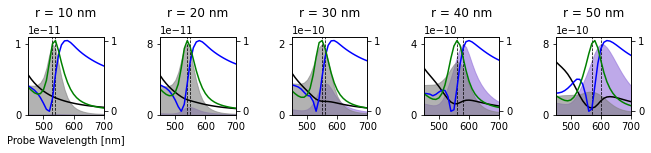

In [2]:
whichalpha='coreshell_MW'
nb = 1.473
power = 500*10 # microwatts

fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
# fig_zp, ax_zp = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)

radius = np.array([10, 20, 30, 40, 50])*1E-7

waverange = np.round(np.arange(400, 720, 10)*1E-7, 7)

pe = Plot_Everything(radius, nb)
pump = np.array([532.E-7]) # waverange
probe = waverange # np.array([785.E-7])

norm_sig = True
wave_pump = pump
wave_probe = probe
nTOT_abs = 1
nTOT_sca = 1
zp = np.arange(-1000, 1000, 10)*1E-7

P0_probe=500*10

if len(wave_pump) > 1:
    wave_pump_array = wave_pump
    wave_probe_array = np.zeros(len(waverange)) + wave_probe
    ax[0].set_xlabel('Pump Wavelength [nm]')
if len(wave_pump) == 1:
    wave_pump_array = np.zeros(len(waverange)) + wave_pump
    wave_probe_array = wave_probe
    ax[0].set_xlabel('Probe Wavelength [nm]')

############################################################
### Loop Through the Radii ###
for idxr, rad_val in enumerate(radius):
    total_signal_max = np.zeros(len(waverange))
    zp_max_PT = np.zeros(len(waverange))
    cobri_tot = np.zeros(len(waverange))
    zp_max_CB = np.zeros(len(waverange))
    scat_tot = np.zeros(len(waverange))
    zp_max_S = np.zeros(len(waverange))
    ############################################################
    #### Plot Mie Theory ####
    mt = Mie_Theory(radius=rad_val, nb=nb, selected_waves=waverange)
    abs_cross_MIE, _, _ = mt.cross_sects(nTOT=nTOT_abs)
    _, sca_cross_MIE, _ = mt.cross_sects(nTOT=nTOT_sca)
    ax[idxr].fill_between(waverange*1E7, sca_cross_MIE, 
                     color='mediumpurple',zorder=0, alpha=.6)
    ax[idxr].fill_between(waverange*1E7, abs_cross_MIE, 
                     color='gray',zorder=1, alpha=.6)
    idx_abs = np.where(abs_cross_MIE == max(abs_cross_MIE))
    max_abs = waverange[idx_abs]
    idx_sca = np.where(sca_cross_MIE == max(sca_cross_MIE))
    max_sca = waverange[idx_sca]
    ax[idxr].plot(np.array([max_abs, max_abs])*1E7, 
        np.array([-1, 1]), color='k', linewidth=0.75, linestyle='dashed')
    ax[idxr].plot(np.array([max_sca, max_sca])*1E7, 
        np.array([-1, 1]), color='k', linewidth=0.75, linestyle='dashed')
    ############################################################
    ### Format Figure ###
    if max(sca_cross_MIE) > max(abs_cross_MIE): whichbig = sca_cross_MIE
    if max(sca_cross_MIE) < max(abs_cross_MIE): whichbig = abs_cross_MIE
    ax[idxr].set_ylim([0, max(whichbig)*1.1])
    ax[idxr].set_xlim(450, 700)
    ax[idxr].set_title(str('r = ')+str(int(np.round(rad_val*1E7)))+str(' nm'), pad=20)
    ax[idxr].set_yticks([0, max(whichbig)])
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax[idxr].yaxis.set_major_formatter(yfmt)
    ############################################################
    #### Find zp to Maximize PT & iSCAT ####
    for idxw, val_wave in enumerate(waverange):
        mt_single = Mie_Theory(radius=rad_val, nb=nb, selected_waves=np.array([wave_pump_array[idxw]]))
        abs_cross, _, _ = mt_single.cross_sects(nTOT_abs)
    #### PT ####
        pt = Photothermal_Image(radius=rad_val, wave_pump=np.array([wave_pump_array[idxw]]),
                                 abs_cross=abs_cross, P0h=power*10, wave_probe=wave_probe_array[idxw], 
                                 kind=whichalpha, nb_T0=nb, define_zp=zp)
        I_sin, S1_sin, S2_sin, _ = pt.pt_signal(which='sin',norm=norm_sig,P0_probe=P0_probe)
        I_cos, S1_cos, S2_cos, _ = pt.pt_signal(which='cos',norm=norm_sig,P0_probe=P0_probe)
        total_signal = np.sqrt( (I_sin + S1_sin + S2_sin)**2 + 
                               (I_cos + S1_cos + S2_cos)**2)
        zp_idx_max = np.where(total_signal == max(total_signal))
        zp_max_PT[idxw] = zp[zp_idx_max]
        total_signal_max[idxw] = total_signal[zp_idx_max]
    #### COBRI ####
        cobri = pt.cobri(cobri_or_scat='cobri')
        zp_idx_max_CB = np.where(cobri == max(cobri))
        zp_max_CB[idxw] = zp[zp_idx_max_CB]
        cobri_tot[idxw] = cobri[zp_idx_max_CB]
        
    #### Scatt ####
        scat = pt.cobri(cobri_or_scat='scat')
        zp_idx_max_S = np.where(scat == max(scat))
        zp_max_S[idxw] = zp[zp_idx_max_S]
        scat_tot[idxw] = scat[zp_idx_max_S]
        
    ############################################################
    #### Plot Photothermal ####
    ax2 = ax[idxr].twinx()
    ax2.plot(waverange*1E7, total_signal_max/max(total_signal_max),'k', zorder=2,linewidth=1.5)
    cobri_tot_adj = cobri_tot - min(cobri_tot)
    ax2.plot(waverange*1E7, cobri_tot_adj/max(cobri_tot_adj),'blue')
    ax2.plot(waverange*1E7, scat_tot/max(scat_tot),'green', zorder=2, linewidth=1.5)

    ax2.set_yticks([0, max(total_signal_max/max(total_signal_max))])
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax2.yaxis.set_major_formatter(yfmt)

    
fig.subplots_adjust(left=.05, bottom=.2, right=.95, 
            top=.8, wspace=.75) 


fig.savefig(str('compare_pt_cobri.png'), 
    dpi=500, bbox_inches='tight',facecolor='white')
















